## Material Group Net Weight Forecasting in O2C process

This script forecasts the net weight of a particular material group over the coming year

### Connect to Celonis

In [1]:
from pycelonis import get_celonis
from pycelonis.pql import PQL, PQLColumn, PQLFilter
celonis = get_celonis()

2020-10-12 10:52:52 - pycelonis: Login successful! The Application Key currently has access to 17 Analyses and to 15 Data Pools.


### Get the O2C Data model from Celonis

In [2]:
dm = celonis.datamodels.find('my_datamodel_id_or_name')

### Get the columns containing historical data for which you want to do the forecast
Date and net weight into a dataframe filter over the particular material group

In [3]:
query = PQL()
query += PQLColumn("VBAP.NTGEW", "Net Weight") # net weight
query += PQLColumn("Round_Day(VBAK.TS_ERDAT)", "Date") # dates
query += PQLFilter("FILTER DOMAIN VBAP.MATKL = '01506'") # Filtering on 1 material group
filtered_results = dm.get_data_frame(query)
filtered_results.head()

,Net Weight,Date
0,1890.0,2009-11-23
1,2835.0,2009-11-23
2,1890.0,2009-11-27
3,2835.0,2009-11-27
4,1890.0,2009-12-03


### Prepare columns for forecast input
Ds: date, y: value to be forecasted

In [4]:
df_weight = filtered_results.rename(columns={"Net Weight": "y", "Date": 'ds'})
df_weight.head()

,y,ds
0,1890.0,2009-11-23
1,2835.0,2009-11-23
2,1890.0,2009-11-27
3,2835.0,2009-11-27
4,1890.0,2009-12-03


### Fit the model for forecasting net weight for the specific material 
Uses external python library fbprophet

In [5]:
from fbprophet import Prophet
# fit forecast model
forecast_model = Prophet()
forecast_model.fit(df_weight)

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


2020-10-12 10:53:18 - numexpr.utils: Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-10-12 10:53:18 - numexpr.utils: NumExpr defaulting to 8 threads.
2020-10-12 10:53:18 - fbprophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Create the future frame over a period of 1 year and predict the net weight
(column yhat shows the predictive values over time)

In [6]:
#Create future df with future dates
future = forecast_model.make_future_dataframe(periods=365)
#Predict for future dates
forecast = forecast_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3264,2021-01-15,9.558880,8.746980,10.334066
3265,2021-01-16,9.405977,8.566520,10.207378
3266,2021-01-17,9.564389,8.744906,10.363235
3267,2021-01-18,9.750164,8.917266,10.506039
3268,2021-01-19,9.634862,8.857531,10.391174


### Plot the forecast
Time on x axis vs forecasted values on y axis for 2021

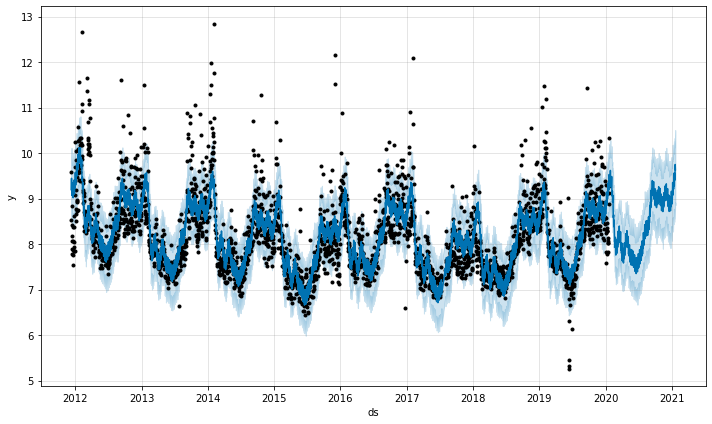

In [7]:
fig1 = forecast_model.plot(forecast)

### Plot trends in the forecast

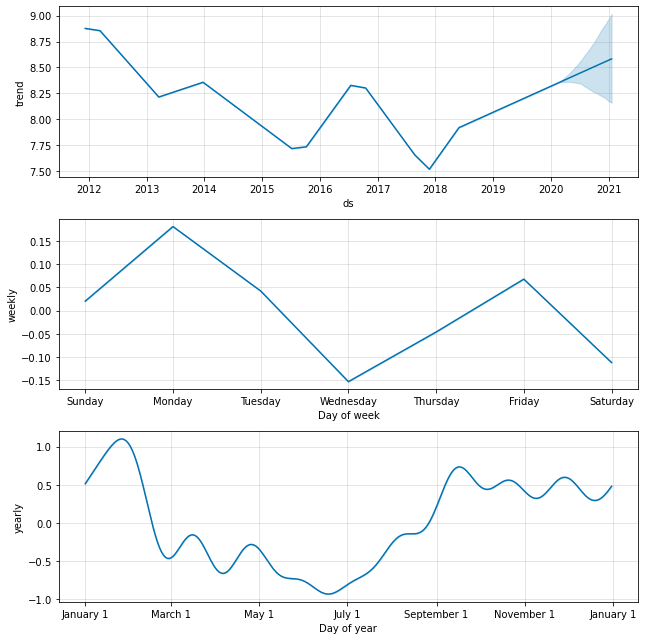

In [8]:
fig2 = forecast_model.plot_components(forecast)

### Push the forecast back to Celonis data model 
Results can then be used in the IBC (Analysis, Actions etc.)

In [ ]:
data_model.push_table(df_weight,"Forecast_netWeight",reload_datamodel=False, if_exists = 'replace')